<h2> Predicting Stock Prices Using TensorFlow <h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
# load data

company ='AMZN'

start = dt.datetime(2018,1,1)
end = dt.datetime(2020,1,1)

data = web.DataReader(company, 'yahoo', start, end)

In [3]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,1190.000000,1170.510010,1172.000000,1189.010010,2694500,1189.010010
2018-01-03,1205.489990,1188.300049,1188.300049,1204.199951,3108800,1204.199951
2018-01-04,1215.869995,1204.660034,1205.000000,1209.589966,3022100,1209.589966
2018-01-05,1229.140015,1210.000000,1217.510010,1229.140015,3544700,1229.140015
2018-01-08,1253.079956,1232.030029,1236.000000,1246.869995,4279500,1246.869995


In [4]:
# Prepare Data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, 
                    (x_train.shape[0], x_train.shape[1],1))


In [5]:
# Build the model

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, 
               input_shape=(x_train.shape[1],1))) 

model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True)) 

model.add(Dropout(0.2))

model.add(LSTM(units=50)) 

model.add(Dropout(0.2))

model.add(Dense(units=1)) # Prediction of the next closing price

model.compile(optimizer='adam', loss='mean_squared_error')

In [6]:
# Train the model

model.fit(x_train, y_train, epochs=100, batch_size=50)

Epoch 1/100
9/9 [==============================] - 5s 48ms/step - loss: 0.2847
Epoch 2/100
9/9 [==============================] - 0s 45ms/step - loss: 0.0400
Epoch 3/100
9/9 [==============================] - 0s 45ms/step - loss: 0.0293
Epoch 4/100
9/9 [==============================] - 0s 43ms/step - loss: 0.0223
Epoch 5/100
9/9 [==============================] - 0s 43ms/step - loss: 0.0172
Epoch 6/100
9/9 [==============================] - 0s 45ms/step - loss: 0.0178
Epoch 7/100
9/9 [==============================] - 0s 45ms/step - loss: 0.0142
Epoch 8/100
9/9 [==============================] - 0s 43ms/step - loss: 0.0148
Epoch 9/100
9/9 [==============================] - 0s 43ms/step - loss: 0.0126
Epoch 10/100
9/9 [==============================] - 0s 43ms/step - loss: 0.0137
Epoch 11/100
9/9 [==============================] - 0s 41ms/step - loss: 0.0136
Epoch 12/100
9/9 [==============================] - 0s 43ms/step - loss: 0.0118
Epoch 13/100
9/9 [==============================]

<h3> Test The Model Accuracy on Existing Data <h3>

In [7]:
# Load Test data

test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)

model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [8]:
# Make prediction on Test data

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test,
                   (x_test.shape[0],x_test.shape[1],1))



In [9]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

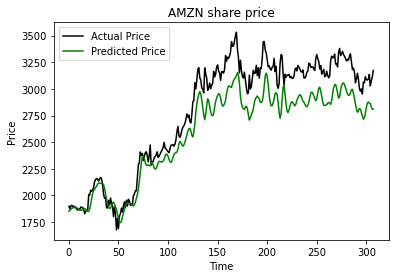

In [10]:
# Plot the test predictions

plt.plot(actual_prices, color='black', label = 'Actual Price')
plt.plot(predicted_prices, color = 'green', label = 'Predicted Price')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f"{company} share price")
plt.legend()

plt.show()